In [191]:
### Imports ###

# Libs
import pandas as pd
import seaborn as sns
import geopandas
import folium
import matplotlib.pyplot as plt
import requests
import emoji
from shapely.geometry import Point
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import ipywidgets as widgets
from ipywidgets import Button, Layout
import IPython.display as dsply
from IPython.display import display
from IPython.display import Image
from IPython.display import clear_output
from ipywidgets import IntSlider, Output
from IPython.display import Markdown as md
from IPython.core.display import HTML

# Images
img = Image(filename="Images/heatmap_guide.png", width=1000, height='auto')

#print("All libraries imported. ")

<img src="Images/logo_PID.png" style="width: 70px;"/>

<a id="top"></a>

In [369]:
HTML("""

<link href="https://fonts.googleapis.com/css2?family=Calligraffitti&family=Lexend+Tera&display=swap" rel="stylesheet"> 

<style>

/* Add a black background color to the top navigation */
.topnav {
  background-color: #8D4E85;
  overflow: hidden;
}

/* Style the links inside the navigation bar */
.topnav a {
  float: left;
  text-align: center;
  color: coral;
  padding: 14px 16px;
  text-decoration: none;
  font-size: 16px;
  font-family: 'Calligraffitti', cursive;
  font-family: 'Lexend Tera', sans-serif;
}

/* Change the color of links on hover */
.topnav a:hover, a:active {
  background-color: #ddd;
  color: black;
}




</style>

 <div class="topnav">
  <a href="#weather" style='color: coral;'>Today's weather</a>
  <a href="#word_cloud" style='color: coral;'>Word Cloud</a>
  <a href="#heatmap" style='color: coral;'>Heatmap</a>
  <a href="#visitors" style='color: coral;'>Total Skatepark Visitors</a>
  <a href="#sport_age" style='color: coral;'>Sport vs Age Group</a>
  <a href="#map" style='color: coral;'>Map: Skateparks in Malmö</a>
</div> 

""")

In [370]:
HTML("""

<link href="https://fonts.googleapis.com/css2?family=Luckiest+Guy&display=swap" rel="stylesheet"> 

<style>
.welcome {
    font-family: 'Luckiest Guy', cursive;
    text-align: center;
    font-size: 38px;
}
.welcome_text {
    text-align: center;
    font-size: 18px;
    font-style: oblique;
}


</style>

<div class="welcome">
  <h2>Welcome to Skateparks in Data</h2>
</div>
<div class="welcome_text">
 Below you can witness different statistics about the skateparks in Malmö.
</div>
<br>


""")

In [371]:
data = "Data/skateparks.csv"

# Read data and parse df['Timestamp] to Timestamp format in DataFrame
df = pd.read_csv(data, parse_dates=['Timestamp'], 
    date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%Y %H:%M:%S'))

In [372]:
# Get API from SMHI
entrypoint = 'https://opendata-download-metfcst.smhi.se/api/category/pmp3g/version/2/geotype/point/lon/13.00073/lat/55.60587/data.json'

# Response saved as result
response = requests.get(entrypoint)
result = response.json()

In [373]:
# Adding variable for temperature
temperature = 0
for i in result['timeSeries'][0]['parameters']:
  if(i['name'] == 't'):
    temperature = i['values']
    temperature = str(temperature).strip('[]')
    temperature = float(temperature)
    #temperature = round(temperature)

In [374]:
# Adding variable for wind
wind = 0
for i in result['timeSeries'][0]['parameters']:
  if(i['name'] == 'ws'):
    wind = i['values']
    wind = str(wind).strip('[]')
    #wind = float(wind)

In [375]:
# Weather symbols, SMHI

weather_symbols = {
    1: 'Clear sky',
    2: 'Nearly clear sky',
    3: 'Variable cloudiness',
    4: 'Halfclear sky',
    5: 'Cloudy sky',
    6: 'Overcast',
    7: 'Fog',
    8: 'Light rain showers',
    9: 'Moderate rain showers',
    10: 'Heavy rain showers',
    11: 'Thunderstorm',
    12: 'Light sleet showers',
    13: 'Moderate sleet showers',
    14: 'Heavy sleet showers',
    15: 'Light snow showers',
    16: 'Moderate snow showers',
    17: 'Heavy snow showers',
    18: 'Light rain',
    19: 'Moderate rain',
    20: 'Heavy rain',
    21: 'Thunder',
    22: 'Light sleet',
    23: 'Moderate sleet',
    24: 'Heavy sleet',
    25: 'Light snowfall',
    26: 'Moderate snowfall',
    27: 'Heavy snowfall', 
}

In [376]:
# Adding weather status as a variabel
weather_stats = 0
for i in result['timeSeries'][0]['parameters']:
  if(i['name'] == 'Wsymb2'):
    weather_stats = i['values']
    weather_stats = str(weather_stats).strip('[]')
    weather_stats = float(weather_stats)
    weather_stats = round(weather_stats)

weather_type = ''
for i in weather_symbols:
  if(weather_stats == i):
    weather_type = weather_symbols[i]

In [377]:
def weather_emoji(weather_stats):
  emoji = ''
  if(weather_stats == 1):
    emoji = '☀️'
  elif(weather_stats == 2):
    emoji = '⛅'
  elif(weather_stats == 3 or 4 or 5 or 6):
    emoji = '☁️'
  elif(weather_stats == 7):
    emoji = '🌫️'
  elif(weather_stats == range(8, 20)):
    emoji = '🌧️'
  elif(weather_stats == 21):
    emoji = '🌩️'
  elif(weather_stats == range(22, 27)):
    emoji = '❄️'

  return emoji    

weather_stats_emoji = weather_emoji(weather_stats)

<a id="weather"></a>

In [378]:
HTML("""

<link href="https://fonts.googleapis.com/css2?family=Calligraffitti&family=Lexend+Tera&display=swap" rel="stylesheet"> 

<style>
.header {
    font-family: 'Calligraffitti', cursive;
    font-family: 'Lexend Tera', sans-serif;
    text-align: center;
    font-weight: bold;
    font-size: 23px;
    color: #8D4E85;
}
</style>

<div class="header">
  <h2>Today's Weather</h2>
</div>


""")

In [379]:
md(f"<h1><center> {weather_stats_emoji}&emsp; &emsp;  🌡 {temperature} ℃ &emsp;&emsp; 🌬️ {wind} m/s  </center></h1> ")  

<h1><center> ⛅&emsp; &emsp;  🌡 21.6 ℃ &emsp;&emsp; 🌬️ 3.4 m/s  </center></h1> 

<h2 style="background-color:#8D4E85; color: #8D4E85;"><center>S</center></h2>

<br><br><br>

<a id="word_cloud"></a>

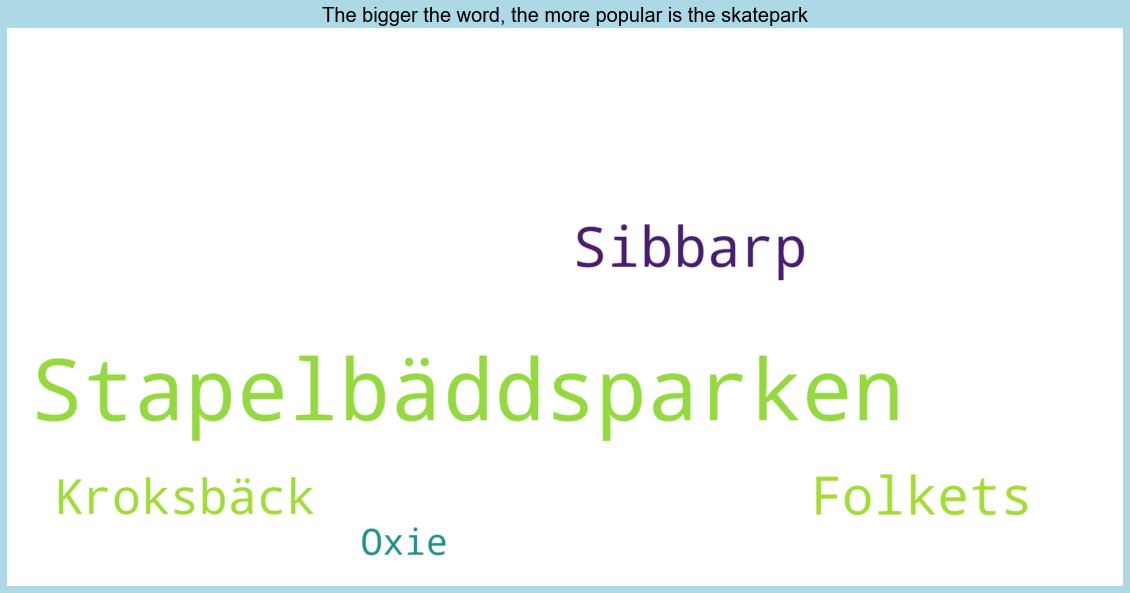

In [380]:
text = df.Skatepark.values
text = " ".join(text)

stopwords = set(STOPWORDS) 
stopwords.update(["skatepark", "park"])

wordcloud = WordCloud(
stopwords = stopwords,
width = 2000,
height = 1000,
collocations=False,
background_color = 'white').generate(str(text))
fig = plt.figure(
figsize = (20, 20))

plt.title('The bigger the word, the more popular is the skatepark', fontsize=20)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off");

[Top of page](#top)

<h2 style="background-color:#8D4E85; color: #8D4E85;"><center>S</center></h2>

<a id="heatmap"></a>

In [381]:
HTML("""

<link href="https://fonts.googleapis.com/css2?family=Calligraffitti&family=Lexend+Tera&display=swap" rel="stylesheet"> 

<style>
.skatepark_hours_header {
    font-family: 'Calligraffitti', cursive;
    font-family: 'Lexend Tera', sans-serif;
    font-weight: bold;
    font-size: 23px;
    color: #8D4E85;
    text-align: center;
}

.text{
    font-family: 'Calligraffitti', cursive;
    font-family: 'Lexend Tera', sans-serif;
    font-weight: bold;
    font-size: 15px;
    text-align: center;
 

}
</style>

<div class="skatepark_hours_header">
  <h2>Most visited skatepark hours</h2>
</div>

<br>

<div class = "text">
  Average check-ins for every weekday at that specific hour.<br> 
  Help us add more data for the heatmap in <a href="https://forms.gle/bnrpm9Uh3p7dtmtU9" target="_blank">THIS</a> form.
</div>


""")

In [382]:
# Make a copy of the DataFrame
df_heatmap = df.copy()

In [383]:
# Counting every check-in for every hour 
df_heatmap = df_heatmap.groupby([pd.Grouper(key='Timestamp',freq='H'),df_heatmap.Skatepark]).size().reset_index(name='Count')

In [384]:
# Add weekday as a new column
df_heatmap['Weekday'] = df_heatmap['Timestamp'].dt.day_name()

In [385]:
# Add hour as a new column
df_heatmap['Hour'] = df_heatmap['Timestamp'].dt.hour

In [386]:
# Make the Weekday column a categorical and specify the order to use.
df_heatmap['Weekday'] = pd.Categorical(df_heatmap['Weekday'], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [387]:
# Sort values by Weekday as specified in pd.Categorical
df_heatmap.sort_values("Weekday");

In [388]:
# Filtering new DataFrames for different skateparks
stapeln = df_heatmap[df_heatmap['Skatepark'] == 'Stapelbäddsparken']
folkets = df_heatmap[df_heatmap['Skatepark'] == 'Folkets Park']
kroks = df_heatmap[df_heatmap['Skatepark'] == 'Kroksbäck Skatepark']
sibbarp = df_heatmap[df_heatmap['Skatepark'] == 'Sibbarp Skatepark']
oxie = df_heatmap[df_heatmap['Skatepark'] == 'Oxie Skatepark']

In [389]:
### Insert button to toggle between show/hide image ###
toggle = widgets.ToggleButton(description='Show/Hide guide')
out = widgets.Output(layout=widgets.Layout(border = '1px solid black'))

def on_click_show_image(obj):
  with out:
    if obj['new']:
      display(img)
    else:
      out.clear_output()
toggle.observe(on_click_show_image, 'value')
display(toggle)
display(out)

ToggleButton(value=False, description='Show/Hide guide')

Output(layout=Layout(border='1px solid black'))

In [390]:
# Function to display heatmap in drop-down box
def display_heatmap(heatmap_df):

  # Pandas pivot 
  heatmap_data = pd.pivot_table(heatmap_df, values = 'Count',
                     index=['Weekday'], 
                     columns='Hour').fillna(0)

  f, ax = plt.subplots(figsize=(15, 10))

  # Seaborn heatmap 
  ax = sns.heatmap(heatmap_data, annot=True, fmt='g',
            linewidths=1.1, linecolor='black', cmap="RdPu",
            square=True,
            cbar_kws=dict(use_gridspec=False,location="top", label="Average number of visitors (low to high)") )
  
  plt.title('Most Visited Skatepark Hours', fontsize=16)
  plt.yticks(rotation=30, fontsize=15)
  plt.xticks(fontsize=15)
  plt.ylabel(None)
  plt.xlabel('Hour of the day', fontsize=15);

In [391]:
@widgets.interact

# Filter skateparks after the unique values in the column
def interactive_test( Skatepark = df_heatmap['Skatepark'].unique()):

  # Display different DataFrames for the heatmap depending on skatepark
  if(Skatepark == 'Stapelbäddsparken'):
    display_heatmap(stapeln)

  if(Skatepark == 'Folkets Park'):
    display_heatmap(folkets)

  if(Skatepark == 'Kroksbäck Skatepark'):
    display_heatmap(kroks)

  if(Skatepark == 'Sibbarp Skatepark'):
    display_heatmap(sibbarp)

  if(Skatepark == 'Oxie Skatepark'):
    display_heatmap(oxie)

interactive(children=(Dropdown(description='Skatepark', options=('Stapelbäddsparken', 'Folkets Park', 'Sibbarp…

[Top of page](#top)

<h2 style="background-color:#8D4E85; color: #8D4E85;"><center>S</center></h2>

<a id="visitors"></a>

In [392]:
HTML("""

<link href="https://fonts.googleapis.com/css2?family=Calligraffitti&family=Lexend+Tera&display=swap" rel="stylesheet"> 

<style>
.total_visitors_header {
    font-family: 'Calligraffitti', cursive;
    font-family: 'Lexend Tera', sans-serif;
    font-weight: bold;
    font-size: 23px;
    color: #8D4E85;
    text-align: center;
}

.text{
    font-family: 'Calligraffitti', cursive;
    font-family: 'Lexend Tera', sans-serif;
    font-weight: bold;
    font-size: 15px;
    text-align: center;
 

}
</style>

<div class="total_visitors_header">
  <h2>Total visitors</h2>
</div>

<br>

<div class = "text">
   Total number of visitors in 5 different skateparks in Malmö.
</div>


""")

In [393]:
# Convert object to int
skateparks_to_value = df['Skatepark'].value_counts()
# skateparks_to_value

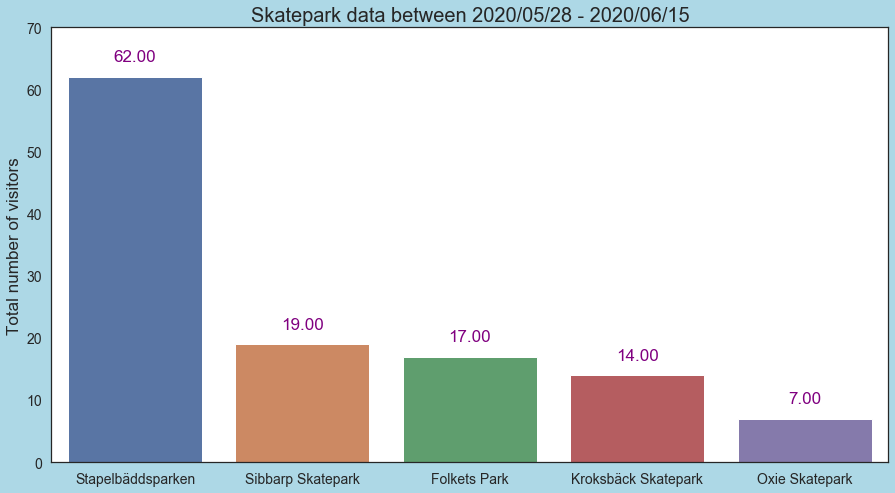

In [394]:
# Create diagram and decide color/size
plt.figure(figsize=(15, 8))
sns.set(style="white") # Set background style.
# Figure background-'/face-' color  =  ax.figure.facecolor:'green'
ax = sns.barplot(skateparks_to_value.index, skateparks_to_value.values, palette='deep')
plt.title('Skatepark data between 2020/05/28 - 2020/06/15', fontsize=20)
plt.ylabel('Total number of visitors', fontsize=17);

# Change font-size within barplot/histogram --> .tick_params(labelsize=5)
ax.tick_params(labelsize=14)

# Add numbers to bars
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=17, color='purple', xytext=(0, 20),
                 textcoords='offset points')
_ = ax.set_ylim(0,70) # To make space for the annotations, Set min/max value on y-axis

[Top of page](#top)

<h2 style="background-color:#8D4E85; color: #8D4E85;"><center>S</center></h2>

<a id="sport_age"></a>

In [395]:
HTML("""

<link href="https://fonts.googleapis.com/css2?family=Calligraffitti&family=Lexend+Tera&display=swap" rel="stylesheet"> 

<style>
.sport_age_header {
    font-family: 'Calligraffitti', cursive;
    font-family: 'Lexend Tera', sans-serif;
    font-weight: bold;
    font-size: 23px;
    color: #8D4E85;
    text-align: center;
}

.sport_age_text{
    font-family: 'Calligraffitti', cursive;
    font-family: 'Lexend Tera', sans-serif;
    font-weight: bold;
    font-size: 15px;
    text-align: center;
 

}
</style>

<div class="sport_age_header">
  <h2>Sport vs Age Group</h2>
</div>

<br>

<div class = "sport_age_text">
See popularity of the different sports compared to every age group below.
   
</div>


""")

In [396]:
df_age_sport = df.copy()

In [397]:
# Counting every checkin for every hour and counting
df_age_sport = df_age_sport.groupby([pd.Grouper(key='Sport'),df_age_sport['Age group']]).size().reset_index(name='Count')

In [398]:
df_age_sport['Age group'] = pd.Categorical(df_age_sport['Age group'], ['0-5', '6-12', '13-19', '20-29', '30-39', '40-49', '50-59', '60+'])
df_age_sport.sort_values("Age group");

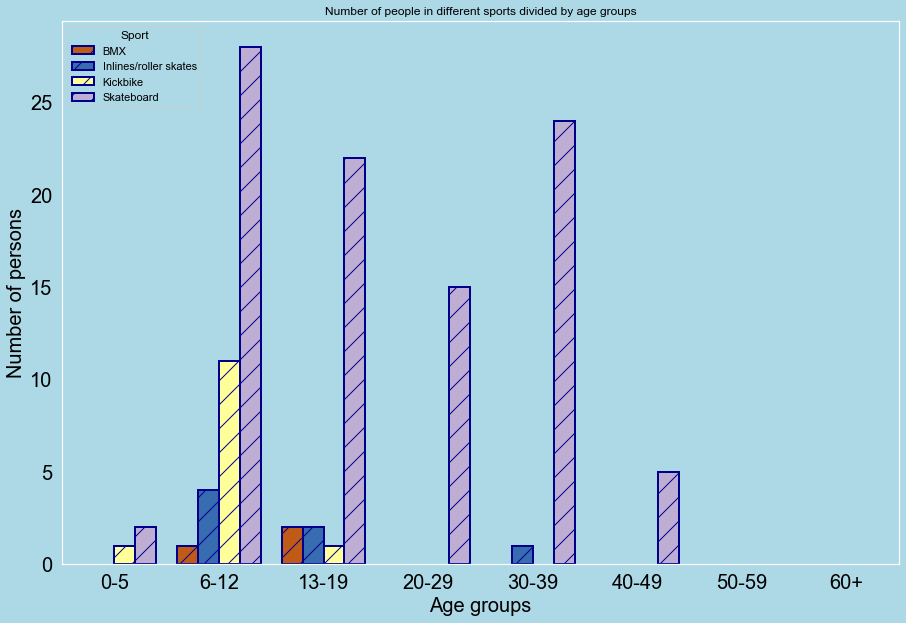

In [399]:
sns.set(rc={"font.style":"normal",
            "axes.facecolor":'lightblue',
            "figure.facecolor":'lightblue',
            "text.color":"black",
            "xtick.color":"black",
            "ytick.color":"black",
            "axes.labelcolor":"black",
            "axes.grid":False,
            'axes.labelsize':20,
            'figure.figsize':(15.0, 10.0),
            'xtick.labelsize':20,
            'font.size':30,
            'ytick.labelsize':20})

sns.barplot(x="Age group", y='Count', hue='Sport', data=df_age_sport, palette='Accent_r',
            edgecolor='darkblue', saturation=1, fill=True, hatch='/', 
                  linewidth=2)

plt.xlabel('Age groups')  
plt.ylabel('Number of persons')  
plt.title('Number of people in different sports divided by age groups');

[Top of page](#top)

<h2 style="background-color:#8D4E85; color: #8D4E85;"><center>S</center></h2>

<a id="map"></a>

In [400]:
HTML("""

<link href="https://fonts.googleapis.com/css2?family=Calligraffitti&family=Lexend+Tera&display=swap" rel="stylesheet"> 

<style>
.map_header {
    font-family: 'Calligraffitti', cursive;
    font-family: 'Lexend Tera', sans-serif;
    font-weight: bold;
    font-size: 23px;
    color: #8D4E85;
    text-align: center;
}

.text{
    font-family: 'Calligraffitti', cursive;
    font-family: 'Lexend Tera', sans-serif;
    font-weight: bold;
    font-size: 15px;
    text-align: center;
 

}
</style>

<div class="map_header">
  <h2>Map: Skateparks in Malmö</h2>
</div>

<br>

<div class = "text">
   Find your way to 5 skateparks in Malmö.<br>
   Link to Google Maps can be found in each pin on the map.
</div>


""")

[Top of page](#top)

In [401]:
stapelbäddsparken_coordinates = [55.613781,12.983913]
#stapelbäddsparken_coordinates[1]

In [402]:
# Skatepark coordinates, stored as dictionary

coordinates_dictionary = {
    (55.613781,12.983913): '<a href="https://www.google.se/maps/place/Stapelb%C3%A4ddsparken+Skatepark/@55.6135451,12.9816805,17z/data=!3m1!4b1!4m5!3m4!1s0x4653a5ed00b7ea67:0x53c9bf8f0eae32d8!8m2!3d55.6135451!4d12.9838693" target="_blank" content="text/html" charset="UTF-32" >Stapelb&auml;ddsparken</a>',
    (55.571860, 12.976309): '<a href="https://www.google.se/maps/place/Kroksb%C3%A4ck+Skatepark/@55.5717058,12.9741414,17z/data=!3m1!4b1!4m5!3m4!1s0x4653a12d7b6da66b:0x66c9bd1cb8c35197!8m2!3d55.5717028!4d12.9763301" target="_blank">Kroksb&auml;ck Skatepark</a>',
    (55.5920945, 13.0127095): '<a href="https://www.google.se/maps/search/Folkets+Park+ramp/@55.5933556,13.0113804,17z/data=!3m1!4b1" target="_blank">Folkets Park</a>',
    (55.574826, 12.908757): '<a href="https://www.google.se/maps/place/Sibbarp+Skate+%26+Activity+Park/@55.5747497,12.9065565,17z/data=!3m1!4b1!4m5!3m4!1s0x4653a6f891c6733d:0xe77b7f75e3d7c49!8m2!3d55.5747467!4d12.9087452" target="_blank">Sibbarp Skatepark</a>',
    (55.541088, 13.103231): '<a href="https://www.google.se/maps/place/Oxie+Skatepark/@55.5409392,13.1010426,17z/data=!3m1!4b1!4m5!3m4!1s0x46539f83f61349ef:0x60a87a2f2a6ccf0f!8m2!3d55.5409362!4d13.1032313" target="_blank">Oxie Skatepark</a>',
}

In [403]:
map = folium.Map(width=1000, location = [55.614709,13.004293], tiles = "OpenStreetMap", zoom_start = 12)

# Looping values with keys with items() method and adding to map
for key, value in coordinates_dictionary.items():
    #print(key, value)
    folium.Marker( key, popup="Skatepark: " + str(value), icon=folium.Icon(color='black', 
                                                                           icon_color='white', 
                                                                           icon='angellist', angle=0, 
                                                                           prefix='fa') ).add_to(map) 
    
# Display map
map

<h2 style="background-color:#8D4E85; color: #8D4E85;"><center>S</center></h2>